In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import time
import sys
import warnings
import math
import json
import requests


import optuna
from optuna.samplers import TPESampler
from matplotlib import pyplot as plt
from sklearn import datasets as dat
from sklearn import model_selection as mod
from sklearn import pipeline as pip
from sklearn import preprocessing as pre
from sklearn import base
from sklearn import impute as imp
from sklearn import ensemble as ens
from sklearn import compose as com
from sklearn import metrics as met
from sklearn import feature_selection as fea
from sklearn import tree
from sklearn import linear_model as lin
from sklearn.metrics import r2_score
import statsmodels.api as sm
from scipy import stats
from sklearn import cluster as clu
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import DBSCAN
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import xgboost.sklearn as xgb
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from statsmodels.graphics.gofplots import qqplot
# DAY OR NIGHT
from astral.sun import sun
from astral import LocationInfo

warnings.filterwarnings("ignore", category=UserWarning)
sys.path.append('../../../')


pd.options.plotting.backend = "plotly"
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import lightgbm as lgbm
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import datetime
import pickle
import sqlalchemy as sa

# For Statistical
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from lofo import LOFOImportance, Dataset, plot_importance
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_log_error,make_scorer
from sklearn.model_selection import GridSearchCV

In [2]:
stores= pd.read_csv("stores.csv")
oil=pd.read_csv("oil.csv")
transactions=pd.read_csv("transactions.csv")
holidays_events=pd.read_csv("holidays_events.csv")
df = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

In [3]:
df['date'] = pd.to_datetime(df['date'])
holidays_events['date'] = pd.to_datetime(holidays_events['date'])
oil['date'] = pd.to_datetime(oil['date'])
transactions['date'] = pd.to_datetime(transactions['date'])

df['date'] = pd.to_datetime(df['date'])
df['store_nbr'] = df['store_nbr'].astype(int)
df['family'] = df['family'].astype(str)
df['sales'] = df['sales'].astype(int)
df['onpromotion'] = df['onpromotion'].astype(int)

merged_df = pd.merge(df, stores, on='store_nbr', how='left')
merged_df = pd.merge(merged_df, oil, on='date', how='left')
merged_df = pd.merge(merged_df, transactions, on=['date', 'store_nbr'], how='left')
merged_df = merged_df.sort_values(by='date', ascending=False)

merged_df.reset_index(drop=True, inplace=True)
merged_df = merged_df.drop(columns=['id'])
df=merged_df

In [4]:
df.head()

,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,dcoilwtico,transactions
0,2017-08-15,9,SEAFOOD,16,0,Quito,Pichincha,B,6,47.57,2155.0
1,2017-08-15,26,BEVERAGES,762,10,Guayaquil,Guayas,D,10,47.57,534.0
2,2017-08-15,25,PERSONAL CARE,93,8,Salinas,Santa Elena,D,1,47.57,849.0
3,2017-08-15,25,PET SUPPLIES,3,0,Salinas,Santa Elena,D,1,47.57,849.0
4,2017-08-15,25,PLAYERS AND ELECTRONICS,3,0,Salinas,Santa Elena,D,1,47.57,849.0


In [5]:
food_and_beverage_categories = [
    'SEAFOOD', 'BEVERAGES', 'POULTRY', 'PREPARED FOODS', 'PRODUCE',
    'BREAD/BAKERY', 'DAIRY', 'DELI', 'EGGS', 'FROZEN FOODS', 'MEATS',
    'LIQUOR,WINE,BEER'
]

household_and_cleaning_categories = ['PERSONAL CARE', 'CLEANING', 'HOME CARE', 'LAWN AND GARDEN']

electronics_and_appliances_categories = ['PLAYERS AND ELECTRONICS', 'HOME APPLIANCES', 'HARDWARE']

apparel_and_personal_items_categories = ['BABY CARE', 'BEAUTY', 'LINGERIE', 'LADIESWEAR']

home_and_office_supplies_categories = ['SCHOOL AND OFFICE SUPPLIES', 'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'CELEBRATION']

miscellaneous_categories = ['PET SUPPLIES', 'AUTOMOTIVE', 'BOOKS', 'MAGAZINES', 'GROCERY I', 'GROCERY II']

# Create a new column 'group' based on the conditions
df['group'] = df['family'].apply(lambda x: 
                                 'food and beverage' if x in food_and_beverage_categories 
                                 else ('household and cleaning' if x in household_and_cleaning_categories 
                                       else ('electronics and appliances' if x in electronics_and_appliances_categories 
                                             else ('apparel and personal items' if x in apparel_and_personal_items_categories 
                                                   else ('home and office supplies' if x in home_and_office_supplies_categories 
                                                         else ('miscellaneous' if x in miscellaneous_categories 
                                                               else 0))))))

In [6]:
df['group'].unique()

array(['food and beverage', 'household and cleaning', 'miscellaneous',
       'electronics and appliances', 'home and office supplies',
       'apparel and personal items'], dtype=object)

In [7]:
df = df.drop(['family'], axis=1)

In [8]:
df.head()

,date,store_nbr,sales,onpromotion,city,state,type,cluster,dcoilwtico,transactions,group
0,2017-08-15,9,16,0,Quito,Pichincha,B,6,47.57,2155.0,food and beverage
1,2017-08-15,26,762,10,Guayaquil,Guayas,D,10,47.57,534.0,food and beverage
2,2017-08-15,25,93,8,Salinas,Santa Elena,D,1,47.57,849.0,household and cleaning
3,2017-08-15,25,3,0,Salinas,Santa Elena,D,1,47.57,849.0,miscellaneous
4,2017-08-15,25,3,0,Salinas,Santa Elena,D,1,47.57,849.0,electronics and appliances


In [9]:
df.describe()

,store_nbr,sales,onpromotion,cluster,dcoilwtico,transactions
count,3.000888e+06,3.000888e+06,3.000888e+06,3.000888e+06,2.072466e+06,2.755104e+06
mean,2.750000e+01,3.576988e+02,2.602770e+00,8.481481e+00,6.792559e+01,1.694602e+03
std,1.558579e+01,1.101976e+03,1.221888e+01,4.649735e+00,2.566633e+01,9.632810e+02
min,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,2.619000e+01,5.000000e+00
25%,1.400000e+01,0.000000e+00,0.000000e+00,4.000000e+00,4.638000e+01,1.046000e+03
50%,2.750000e+01,1.100000e+01,0.000000e+00,8.500000e+00,5.333000e+01,1.393000e+03
75%,4.100000e+01,1.950000e+02,0.000000e+00,1.300000e+01,9.580000e+01,2.079000e+03
max,5.400000e+01,1.247170e+05,7.410000e+02,1.700000e+01,1.106200e+02,8.359000e+03


In [10]:
df.head()

,date,store_nbr,sales,onpromotion,city,state,type,cluster,dcoilwtico,transactions,group
0,2017-08-15,9,16,0,Quito,Pichincha,B,6,47.57,2155.0,food and beverage
1,2017-08-15,26,762,10,Guayaquil,Guayas,D,10,47.57,534.0,food and beverage
2,2017-08-15,25,93,8,Salinas,Santa Elena,D,1,47.57,849.0,household and cleaning
3,2017-08-15,25,3,0,Salinas,Santa Elena,D,1,47.57,849.0,miscellaneous
4,2017-08-15,25,3,0,Salinas,Santa Elena,D,1,47.57,849.0,electronics and appliances


In [11]:
df['DayOfWeek'] = df['date'].dt.dayofweek
df['date'] = pd.to_datetime(df['date'])
df['Week'] = df['date'].dt.week
df['Month'] = df['date'].dt.month
df["Quarter"] = df["date"].dt.quarter
df["Year"] = df["date"].dt.year
df["WeekOfYear"] = df["date"].dt.weekofyear

C:\Users\gulsemin.basaran\AppData\Local\Temp\ipykernel_46560\48554092.py:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['Week'] = df['date'].dt.week
C:\Users\gulsemin.basaran\AppData\Local\Temp\ipykernel_46560\48554092.py:7: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df["WeekOfYear"] = df["date"].dt.weekofyear


In [12]:
df.head()

,date,store_nbr,sales,onpromotion,city,state,type,cluster,dcoilwtico,transactions,group,DayOfWeek,Week,Month,Quarter,Year,WeekOfYear
0,2017-08-15,9,16,0,Quito,Pichincha,B,6,47.57,2155.0,food and beverage,1,33,8,3,2017,33
1,2017-08-15,26,762,10,Guayaquil,Guayas,D,10,47.57,534.0,food and beverage,1,33,8,3,2017,33
2,2017-08-15,25,93,8,Salinas,Santa Elena,D,1,47.57,849.0,household and cleaning,1,33,8,3,2017,33
3,2017-08-15,25,3,0,Salinas,Santa Elena,D,1,47.57,849.0,miscellaneous,1,33,8,3,2017,33
4,2017-08-15,25,3,0,Salinas,Santa Elena,D,1,47.57,849.0,electronics and appliances,1,33,8,3,2017,33


C:\Users\gulsemin.basaran\AppData\Local\Temp\ipykernel_46560\2208088809.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


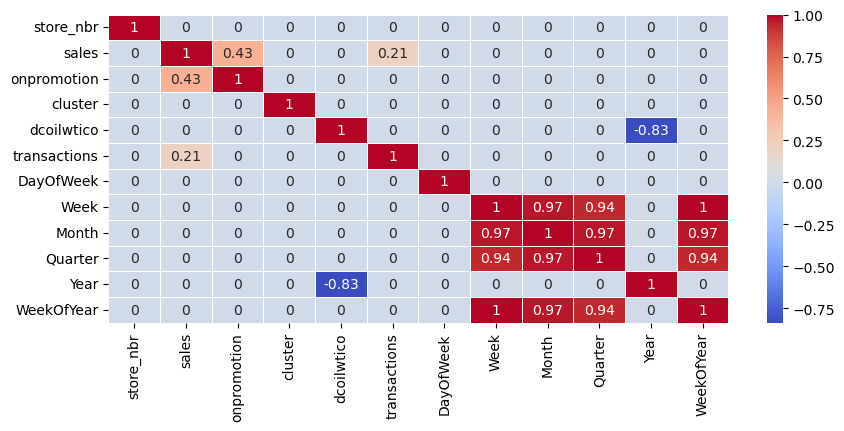

In [13]:
corr = df.corr()
high_corr = corr[abs(corr) > 0.2].fillna(0)
plt.figure(figsize=(10, 4))
sns.heatmap(high_corr, cmap='coolwarm', annot=True, linewidths=.5)
plt.show()

In [14]:
"""def time_feat_exct(df):
    df["date"] = pd.to_datetime(df["date"])
    df["start_dow_cos"] = np.cos(2 * np.pi * df["DayOfWeek"] / 6.0).astype(int)
    df["start_dow_sin"] = np.sin(2 * np.pi * df["DayOfWeek"] / 6.0).astype(int)

    df['start_week_cos'] = np.cos(2 * np.pi * df["Week"] / 51.0).astype(int)
    df['start_week_sin'] = np.sin(2 * np.pi * df["Week"] / 51.0).astype(int)

    df['start_month_cos'] = np.cos(2 * np.pi * df["Month"] / 12.0).astype(int)
    df['start_month_sin'] = np.sin(2 * np.pi * df["Month"] / 12.0).astype(int)
    return df"""

'def time_feat_exct(df):\n    df["date"] = pd.to_datetime(df["date"])\n    df["start_dow_cos"] = np.cos(2 * np.pi * df["DayOfWeek"] / 6.0).astype(int)\n    df["start_dow_sin"] = np.sin(2 * np.pi * df["DayOfWeek"] / 6.0).astype(int)\n\n    df[\'start_week_cos\'] = np.cos(2 * np.pi * df["Week"] / 51.0).astype(int)\n    df[\'start_week_sin\'] = np.sin(2 * np.pi * df["Week"] / 51.0).astype(int)\n\n    df[\'start_month_cos\'] = np.cos(2 * np.pi * df["Month"] / 12.0).astype(int)\n    df[\'start_month_sin\'] = np.sin(2 * np.pi * df["Month"] / 12.0).astype(int)\n    return df'

In [15]:
"""df=time_feat_exct(df)"""

'df=time_feat_exct(df)'

In [16]:
df = df.drop(['date'], axis=1)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 16 columns):
 #   Column        Dtype  
---  ------        -----  
 0   store_nbr     int32  
 1   sales         int32  
 2   onpromotion   int32  
 3   city          object 
 4   state         object 
 5   type          object 
 6   cluster       int64  
 7   dcoilwtico    float64
 8   transactions  float64
 9   group         object 
 10  DayOfWeek     int64  
 11  Week          int64  
 12  Month         int64  
 13  Quarter       int64  
 14  Year          int64  
 15  WeekOfYear    int64  
dtypes: float64(2), int32(3), int64(7), object(4)
memory usage: 332.0+ MB


In [18]:
"""phrase_cols = [col for col in df.columns if "temperature" in col]

# Lagged
for i in [1, 2, 3, 23, 24]:
    for col in phrase_cols:
        df[col + "_{}h_lagged".format(i)] = df[col].shift(i)"""

'phrase_cols = [col for col in df.columns if "temperature" in col]\n\n# Lagged\nfor i in [1, 2, 3, 23, 24]:\n    for col in phrase_cols:\n        df[col + "_{}h_lagged".format(i)] = df[col].shift(i)'

In [19]:
"""# Lead
phrase_cols = [col for col in df.columns if
               "temperature" in col or "wxPhraseLong" in col or "UvIndex" in col]
for i in [1, 2, 3, 4]:
    for col in phrase_cols:
        df[col + "_{}h_lead".format(i)] = df[col].shift(-i)"""

'# Lead\nphrase_cols = [col for col in df.columns if\n               "temperature" in col or "wxPhraseLong" in col or "UvIndex" in col]\nfor i in [1, 2, 3, 4]:\n    for col in phrase_cols:\n        df[col + "_{}h_lead".format(i)] = df[col].shift(-i)'

In [20]:
df.isnull().sum()

store_nbr            0
sales                0
onpromotion          0
city                 0
state                0
type                 0
cluster              0
dcoilwtico      928422
transactions    245784
group                0
DayOfWeek            0
Week                 0
Month                0
Quarter              0
Year                 0
WeekOfYear           0
dtype: int64

In [21]:
cat_columns = list(df.select_dtypes(include="object").columns)
cat_columns

['city', 'state', 'type', 'group']

In [22]:
num_columns = list(df.select_dtypes(exclude = "object").columns[3:])
num_columns

['cluster',
 'dcoilwtico',
 'transactions',
 'DayOfWeek',
 'Week',
 'Month',
 'Quarter',
 'Year',
 'WeekOfYear']

In [23]:
X = df.drop('sales', axis=1)
y = df['sales']

In [24]:
X_train, X_test, y_train, y_test = mod.train_test_split(X, y, test_size=0.33, random_state=42)

In [25]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2010594, 15)
(990294, 15)
(2010594,)
(990294,)


In [26]:
"""fig, ax = plt.subplots(figsize=(8, 5))
sns.boxplot(data=X_train, x='Month', y=y_train, palette='Blues')
ax.set_title('MW by Month')
plt.show()"""

"fig, ax = plt.subplots(figsize=(8, 5))\nsns.boxplot(data=X_train, x='Month', y=y_train, palette='Blues')\nax.set_title('MW by Month')\nplt.show()"

In [32]:
pipe_num = pip.Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", pre.StandardScaler()),
])


pipe_cat = pip.Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("enc", pre.OneHotEncoder(handle_unknown="ignore")),
])

ct = com.ColumnTransformer([
    ('num', pipe_num, ['cluster','dcoilwtico','transactions','DayOfWeek','Week','Month','Quarter','Year','WeekOfYear']),
    ('cat', pipe_cat, ['city', 'state', 'type', 'group'])
])

pip_final = pip.Pipeline([
    ('ct', ct),
    ('model', xgb.XGBRegressor(seed=42))
])

params = {
    'model__learning_rate': [0.03, 0.1],
    'model__n_estimators' : [100,148,200],
    'model__max_depth' : [6,10,20]
}


def rmsle(y_true,y_pred):
    return np.sqrt(mean_squared_log_error(y_true,y_pred))

rsmles_scorer=make_scorer(rmsle,greater_is_better=False)

grid = GridSearchCV(pip_final,
                    param_grid = params,
                    scoring = rsmles_scorer,
                    cv = TimeSeriesSplit(n_splits=3),
                   )


In [ ]:
grid.fit(X_train, y_train)

In [ ]:
best_estimator = grid.best_estimator_
y_pred = best_estimator.predict(X_test)

y_pred_non_negative = np.maximum(y_pred, 0)
y_test_non_negative = np.maximum(y_test, 0)

# Calculate RMSLE
rsmles_score = rmsle(y_test_non_negative, y_pred_non_negative)
print("rsmles_score:", rsmles_score)

In [ ]:
"""reg = xgb.XGBRegressor(n_estimators = 148,
                       #objective = 'reg:squarederror',
                       learning_rate = 0.03,
                       max_depth = 6,
                       subsample = 0.6,
                       reg_lambda=1,
                        reg_alpha= 0.2,
                        min_child_weight= 3,
                        gamma= 0.3,
                        colsample_bytree= 0.7
                      )

reg.fit(X_train, y_train)"""

In [ ]:
df_test['date'] = pd.to_datetime(df_test['date'])
df_test['date'] = pd.to_datetime(df_test['date'])
df_test['store_nbr'] = df_test['store_nbr'].astype(int)
df_test['family'] = df_test['family'].astype(str)
df_test['onpromotion'] = df_test['onpromotion'].astype(int)

merged_df = pd.merge(df_test, stores, on='store_nbr', how='left')
merged_df = pd.merge(merged_df, oil, on='date', how='left')
merged_df = pd.merge(merged_df, transactions, on=['date', 'store_nbr'], how='left')
merged_df = merged_df.sort_values(by='date', ascending=False)

merged_df.reset_index(drop=True, inplace=True)
merged_df = merged_df.drop(columns=['id'])
df_test=merged_df

In [ ]:
food_and_beverage_categories = [
    'SEAFOOD', 'BEVERAGES', 'POULTRY', 'PREPARED FOODS', 'PRODUCE',
    'BREAD/BAKERY', 'DAIRY', 'DELI', 'EGGS', 'FROZEN FOODS', 'MEATS',
    'LIQUOR,WINE,BEER'
]

household_and_cleaning_categories = ['PERSONAL CARE', 'CLEANING', 'HOME CARE', 'LAWN AND GARDEN']

electronics_and_appliances_categories = ['PLAYERS AND ELECTRONICS', 'HOME APPLIANCES', 'HARDWARE']

apparel_and_personal_items_categories = ['BABY CARE', 'BEAUTY', 'LINGERIE', 'LADIESWEAR']

home_and_office_supplies_categories = ['SCHOOL AND OFFICE SUPPLIES', 'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'CELEBRATION']

miscellaneous_categories = ['PET SUPPLIES', 'AUTOMOTIVE', 'BOOKS', 'MAGAZINES', 'GROCERY I', 'GROCERY II']

# Create a new column 'group' based on the conditions
df_test['group'] = df_test['family'].apply(lambda x: 
                                 'food and beverage' if x in food_and_beverage_categories 
                                 else ('household and cleaning' if x in household_and_cleaning_categories 
                                       else ('electronics and appliances' if x in electronics_and_appliances_categories 
                                             else ('apparel and personal items' if x in apparel_and_personal_items_categories 
                                                   else ('home and office supplies' if x in home_and_office_supplies_categories 
                                                         else ('miscellaneous' if x in miscellaneous_categories 
                                                               else 0))))))

In [ ]:
df_test = df_test.drop(['family'], axis=1)

In [ ]:
df_test['DayOfWeek'] = df_test['date'].dt.dayofweek
df_test['date'] = pd.to_datetime(df_test['date'])
df_test['Week'] = df_test['date'].dt.week
df_test['Month'] = df_test['date'].dt.month
df_test["Quarter"] = df_test["date"].dt.quarter
df_test["Year"] = df_test["date"].dt.year
df_test["WeekOfYear"] = df_test["date"].dt.weekofyear

In [ ]:
"""def time_feat_exct(df_test):
    df_test["date"] = pd.to_datetime(df_test["date"])
    df_test["start_dow_cos"] = np.cos(2 * np.pi * df_test["DayOfWeek"] / 6.0).astype(int)
    df_test["start_dow_sin"] = np.sin(2 * np.pi * df_test["DayOfWeek"] / 6.0).astype(int)

    df_test['start_week_cos'] = np.cos(2 * np.pi * df_test["Week"] / 51.0).astype(int)
    df_test['start_week_sin'] = np.sin(2 * np.pi * df_test["Week"] / 51.0).astype(int)

    df_test['start_month_cos'] = np.cos(2 * np.pi * df_test["Month"] / 12.0).astype(int)
    df_test['start_month_sin'] = np.sin(2 * np.pi * df_test["Month"] / 12.0).astype(int)
    return df_test"""

In [ ]:
"""df_test=time_feat_exct(df_test)"""

In [ ]:
df_test = df_test.drop(['date'], axis=1)

In [ ]:
best_estimator.fit(X,y)

In [ ]:
y_pred = best_estimator.predict(df_test)
submit_df = pd.DataFrame({'id': df_test.index, 'sales': y_pred})
print(submit_df)


submit_df.to_csv('submit2.csv', index=False)